In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, balanced_accuracy_score, f1_score, RocCurveDisplay
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import GradientBoostingClassifier
import lightgbm

In [5]:
label_dataset_2015 = pd.read_csv("/Users/seanathon48/Desktop/CS_534/Final_Project/archive/DRIAMS-A/id/2015/2015_clean.csv")
label_dataset_2016 = pd.read_csv("/Users/seanathon48/Desktop/CS_534/Final_Project/archive/DRIAMS-A/id/2016/2016_clean.csv")
label_dataset_2017 = pd.read_csv("/Users/seanathon48/Desktop/CS_534/Final_Project/archive/DRIAMS-A/id/2017/2017_clean.csv")
label_dataset_2018 = pd.read_csv("/Users/seanathon48/Desktop/CS_534/Final_Project/archive/DRIAMS-A/id/2018/2018_clean.csv")

/var/folders/v0/37fzp2hx3ns37mhx_9_xr5qh0000gn/T/ipykernel_64636/1115557230.py:3: DtypeWarning: Columns (71) have mixed types. Specify dtype option on import or set low_memory=False.
  label_dataset_2017 = pd.read_csv("/Users/seanathon48/Desktop/CS_534/Final_Project/archive/DRIAMS-A/id/2017/2017_clean.csv")


In [195]:
def proprocess_data(data_2015, data_2016, data_2017, data_2018, drug_name):
    data_2015 = data_2015.loc[data_2015['species'] == "Escherichia coli"]
    data_2016 = data_2016.loc[data_2016['species'] == "Escherichia coli"]
    data_2017 = data_2017.loc[data_2017['species'] == "Escherichia coli"]
    data_2018 = data_2018.loc[data_2018['species'] == "Escherichia coli"]
    
    only_drug_15 = data_2015[['code', drug_name]].dropna()
    only_drug_16 = data_2016[['code', drug_name]].dropna()
    only_drug_17 = data_2017[['code', drug_name]].dropna()
    only_drug_18 = data_2018[['code', drug_name]].dropna()
    
    print("Assembling 2015 DRIAMS data...")
    starting_dataset_15 = np.zeros((only_drug_15.shape[0], 6000))
    base_path = "/Users/seanathon48/Desktop/CS_534/Final_Project/archive/DRIAMS-A/binned_6000/2015/"
    for i in range(only_drug_15.shape[0]):
        starting_dataset_15[i] = np.loadtxt(base_path + only_drug_15.iloc[i]["code"] + ".txt", skiprows = 1, usecols = 1)
    
    print("Assembling 2016 DRIAMS data...")
    starting_dataset_16 = np.zeros((only_drug_16.shape[0], 6000))
    base_path = "/Users/seanathon48/Desktop/CS_534/Final_Project/archive/DRIAMS-A/binned_6000/2016/"
    for i in range(only_drug_16.shape[0]):
        starting_dataset_16[i] = np.loadtxt(base_path + only_drug_16.iloc[i]["code"] + ".txt", skiprows = 1, usecols = 1)

    print("Assembling 2017 DRIAMS data...")        
    starting_dataset_17 = np.zeros((only_drug_17.shape[0], 6000))
    base_path = "/Users/seanathon48/Desktop/CS_534/Final_Project/archive/DRIAMS-A/binned_6000/2017/"
    for i in range(only_drug_17.shape[0]):
        starting_dataset_17[i] = np.loadtxt(base_path + only_drug_17.iloc[i]["code"] + ".txt", skiprows = 1, usecols = 1)
        
    print("Assembling 2018 DRIAMS data...")
    starting_dataset_18 = np.zeros((only_drug_18.shape[0], 6000))
    base_path = "/Users/seanathon48/Desktop/CS_534/Final_Project/archive/DRIAMS-A/binned_6000/2018/"
    for i in range(only_drug_18.shape[0]):
        starting_dataset_18[i] = np.loadtxt(base_path + only_drug_18.iloc[i]["code"] + ".txt", skiprows = 1, usecols = 1)
        
    e_coli_numpy_15 = np.hstack((starting_dataset_15, np.array(only_drug_15[drug_name]).reshape(only_drug_15.shape[0], 1)))
    e_coli_numpy_16 = np.hstack((starting_dataset_16, np.array(only_drug_16[drug_name]).reshape(only_drug_16.shape[0], 1)))
    e_coli_numpy_17 = np.hstack((starting_dataset_17, np.array(only_drug_17[drug_name]).reshape(only_drug_17.shape[0], 1)))
    e_coli_numpy_18 = np.hstack((starting_dataset_18, np.array(only_drug_18[drug_name]).reshape(only_drug_18.shape[0], 1)))
    
    e_coli_numpy = np.vstack((e_coli_numpy_15, e_coli_numpy_16, e_coli_numpy_17, e_coli_numpy_18))
    
    column_list = []
    for i in range(1, 6001):
        column_list.append("Bin " + str(i))
    column_list.append("Class")
    
    e_coli_df = pd.DataFrame(e_coli_numpy, columns = column_list)
    
    e_coli_df = e_coli_df[(e_coli_df['Class'] == "S") | (e_coli_df['Class'] == "R")]
    
    e_coli_df_X = e_coli_df.iloc[:,:-1]
    e_coli_df_y = e_coli_df.iloc[:,-1]
    
    e_coli_df_X = e_coli_df_X.astype(np.float64)
    e_coli_df_y[e_coli_df_y == "S"] = 0
    e_coli_df_y[e_coli_df_y == "R"] = 1
    e_coli_df_y = e_coli_df_y.astype(np.int64)
    
    test = {'boosting_type': 'gbdt', 'learning_rate': 0.001, 'n_estimators': 2000}
    
    e_coli_df_X_train, e_coli_df_X_val_test, e_coli_df_y_train, e_coli_df_y_val_test = train_test_split(e_coli_df_X, e_coli_df_y, stratify=e_coli_df_y, test_size=0.2, random_state=42)
    e_coli_df_X_val, e_coli_df_X_test, e_coli_df_y_val, e_coli_df_y_test = train_test_split(e_coli_df_X_val_test, e_coli_df_y_val_test, test_size=0.50, stratify=e_coli_df_y_val_test, random_state=42)
    
    print("Performing Regular LightGBM Model Evaluation...")
    regular_lightgbm = lightgbm.LGBMClassifier(objective="binary", seed=42, verbose = -1, **test)
    
    _ = regular_lightgbm.fit(e_coli_df_X_train, e_coli_df_y_train, eval_set = (e_coli_df_X_val, e_coli_df_y_val), callbacks = [lightgbm.early_stopping(50)])
    
    e_coli_df_y_pred = regular_lightgbm.predict(e_coli_df_X_test)
    without_smote_roc_auc = roc_auc_score(e_coli_df_y_test, e_coli_df_y_pred)
    without_smote_accuracy = accuracy_score(e_coli_df_y_test, e_coli_df_y_pred)
    without_smote_f1_score = f1_score(e_coli_df_y_test, e_coli_df_y_pred)
    
    e_coli_df_X_train_resampled, e_coli_df_y_train_resampled = SMOTE(random_state=42).fit_resample(e_coli_df_X_train, e_coli_df_y_train)
    
    test = {'boosting_type': 'gbdt', 'learning_rate': 0.001, 'n_estimators': 2000}
    
    print("Performing Oversampled LightGBM Model Evaluation...")    
    smote_lightgbm = lightgbm.LGBMClassifier(objective="binary", seed=42, verbose = -1, **test)
    
    _ = smote_lightgbm.fit(e_coli_df_X_train_resampled, e_coli_df_y_train_resampled, eval_set = (e_coli_df_X_val, e_coli_df_y_val), callbacks = [lightgbm.early_stopping(50)])

    e_coli_df_y_pred_resampled = smote_lightgbm.predict(e_coli_df_X_test)
    with_smote_roc_auc = roc_auc_score(e_coli_df_y_test, e_coli_df_y_pred_resampled)
    with_smote_accuracy = accuracy_score(e_coli_df_y_test, e_coli_df_y_pred_resampled)
    with_smote_f1_score = f1_score(e_coli_df_y_test, e_coli_df_y_pred_resampled)
    
#     fpr_regular, tpr_regular, thresholds = roc_curve(ceftriaxone_y_test, regular_lightgbm.predict_proba(ceftriaxone_X_test)[:, 1], pos_label=1)
#     auc = round(roc_auc_score(ceftriaxone_y_test, ceftriaxone_y_pred), 4)
#     plt.plot(fpr_regular, tpr_regular, label="Without SMOTE, AUC=" + str(auc))

#     fpr_smote, tpr_smote, thresholds = roc_curve(ceftriaxone_y_test, smote_lightgbm.predict_proba(ceftriaxone_X_test)[:, 1], pos_label=1)
#     auc = round(roc_auc_score(ceftriaxone_y_test, ceftriaxone_y_pred_resampled), 4)
#     plt.plot(fpr_smote, tpr_smote, label="With SMOTE, AUC=" + str(auc))
#     plt.xlabel("False Positive Rate")
#     plt.ylabel("True Positive Rate")
#     plt.title("ROC Curves for E. Coli using LightGBM - Ceftriaxone Antibiotic")
#     plt.legend(loc = "lower right")
    print("Done!")
    return [[without_smote_roc_auc, without_smote_accuracy, without_smote_f1_score], [with_smote_roc_auc, with_smote_accuracy, with_smote_f1_score]]

In [52]:
e_coli_ceftriaxone_results = proprocess_data(label_dataset_2015, label_dataset_2016, 
                                        label_dataset_2017, label_dataset_2018, "Ceftriaxone")

Assembling 2015 DRIAMS data...
Assembling 2016 DRIAMS data...


KeyboardInterrupt: 

In [91]:
e_coli_ciprofloxacin_results = proprocess_data(label_dataset_2015, label_dataset_2016, 
                                        label_dataset_2017, label_dataset_2018, "Ciprofloxacin")

Assembling 2015 DRIAMS data...
Assembling 2016 DRIAMS data...
Assembling 2017 DRIAMS data...
Assembling 2018 DRIAMS data...
Performing Regular LightGBM Model Evaluation...
[1]	valid_0's binary_logloss: 0.581241
[2]	valid_0's binary_logloss: 0.567457
[3]	valid_0's binary_logloss: 0.552948
[4]	valid_0's binary_logloss: 0.542795
[5]	valid_0's binary_logloss: 0.534958
[6]	valid_0's binary_logloss: 0.526616
[7]	valid_0's binary_logloss: 0.518546
[8]	valid_0's binary_logloss: 0.513879
[9]	valid_0's binary_logloss: 0.506885
[10]	valid_0's binary_logloss: 0.500684
[11]	valid_0's binary_logloss: 0.496079
[12]	valid_0's binary_logloss: 0.491511
[13]	valid_0's binary_logloss: 0.485845
[14]	valid_0's binary_logloss: 0.47967
[15]	valid_0's binary_logloss: 0.475412
[16]	valid_0's binary_logloss: 0.471435
[17]	valid_0's binary_logloss: 0.466934
[18]	valid_0's binary_logloss: 0.46525
[19]	valid_0's binary_logloss: 0.461793
[20]	valid_0's binary_logloss: 0.459851
[21]	valid_0's binary_logloss: 0.459635

In [196]:
e_coli_cefepime_results = proprocess_data(label_dataset_2015, label_dataset_2016, 
                                        label_dataset_2017, label_dataset_2018, "Cefepime")

Assembling 2015 DRIAMS data...
Assembling 2016 DRIAMS data...
Assembling 2017 DRIAMS data...
Assembling 2018 DRIAMS data...
Performing Regular LightGBM Model Evaluation...
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1797]	valid_0's binary_logloss: 0.228413
Performing Oversampled LightGBM Model Evaluation...
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[2000]	valid_0's binary_logloss: 0.294222
Done!


In [164]:
e_coli_piperacillin_results = proprocess_data(label_dataset_2015, label_dataset_2016, 
                                        label_dataset_2017, label_dataset_2018, "Piperacillin-Tazobactam")

Assembling 2015 DRIAMS data...
Assembling 2016 DRIAMS data...
Assembling 2017 DRIAMS data...
Assembling 2018 DRIAMS data...
Performing Regular LightGBM Model Evaluation...
[1]	valid_0's binary_logloss: 0.235529
[2]	valid_0's binary_logloss: 0.235496
[3]	valid_0's binary_logloss: 0.235464
[4]	valid_0's binary_logloss: 0.235435
[5]	valid_0's binary_logloss: 0.235437
[6]	valid_0's binary_logloss: 0.235403
[7]	valid_0's binary_logloss: 0.235361
[8]	valid_0's binary_logloss: 0.235354
[9]	valid_0's binary_logloss: 0.23534
[10]	valid_0's binary_logloss: 0.235293
[11]	valid_0's binary_logloss: 0.235256
[12]	valid_0's binary_logloss: 0.235251
[13]	valid_0's binary_logloss: 0.23524
[14]	valid_0's binary_logloss: 0.235181
[15]	valid_0's binary_logloss: 0.235152
[16]	valid_0's binary_logloss: 0.235108
[17]	valid_0's binary_logloss: 0.235098
[18]	valid_0's binary_logloss: 0.235058
[19]	valid_0's binary_logloss: 0.234995
[20]	valid_0's binary_logloss: 0.234952
[21]	valid_0's binary_logloss: 0.234901

In [185]:
e_coli_tobramycin_results = proprocess_data(label_dataset_2015, label_dataset_2016, 
                                        label_dataset_2017, label_dataset_2018, "Tobramycin")

Assembling 2015 DRIAMS data...
Assembling 2016 DRIAMS data...
Assembling 2017 DRIAMS data...
Assembling 2018 DRIAMS data...
Performing Regular LightGBM Model Evaluation...
[1]	valid_0's binary_logloss: 0.374699
[2]	valid_0's binary_logloss: 0.374626
[3]	valid_0's binary_logloss: 0.374557
[4]	valid_0's binary_logloss: 0.374486
[5]	valid_0's binary_logloss: 0.374433
[6]	valid_0's binary_logloss: 0.374355
[7]	valid_0's binary_logloss: 0.374296
[8]	valid_0's binary_logloss: 0.374243
[9]	valid_0's binary_logloss: 0.374189
[10]	valid_0's binary_logloss: 0.374119
[11]	valid_0's binary_logloss: 0.374069
[12]	valid_0's binary_logloss: 0.374016
[13]	valid_0's binary_logloss: 0.373972
[14]	valid_0's binary_logloss: 0.373924
[15]	valid_0's binary_logloss: 0.373874
[16]	valid_0's binary_logloss: 0.373795
[17]	valid_0's binary_logloss: 0.373753
[18]	valid_0's binary_logloss: 0.373683
[19]	valid_0's binary_logloss: 0.373633
[20]	valid_0's binary_logloss: 0.373571
[21]	valid_0's binary_logloss: 0.3735

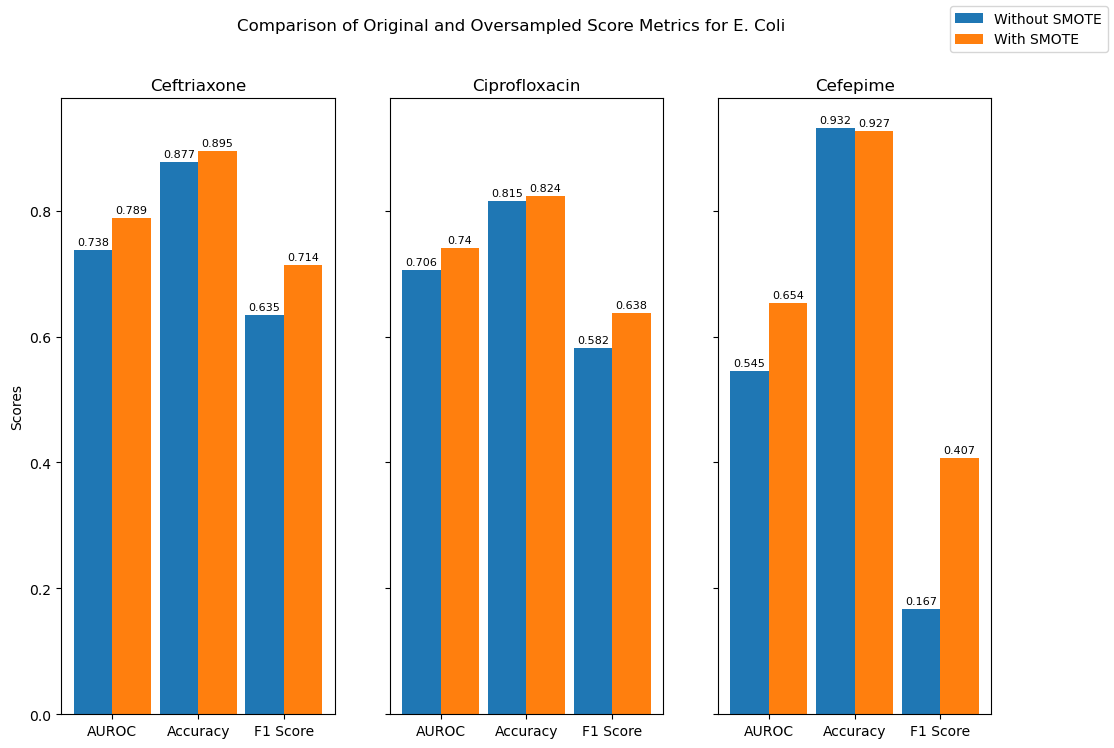

In [189]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 8))

labels = ['AUROC', 'Accuracy', 'F1 Score']
x = np.arange(len(labels))  # the label locations
width = 0.45  # the width of the bars

rects1 = ax0.bar(x - width/2, np.array(e_coli_ceftriaxone_results[0]).round(3), width, label='Without SMOTE')
rects2 = ax0.bar(x + width/2, np.array(e_coli_ceftriaxone_results[1]).round(3), width, label='With SMOTE')

rects3 = ax1.bar(x - width/2, np.array(e_coli_ciprofloxacin_results[0]).round(3), width)
rects4 = ax1.bar(x + width/2, np.array(e_coli_ciprofloxacin_results[1]).round(3), width)

rects5 = ax2.bar(x - width/2, np.array(e_coli_cefepime_results[0]).round(3), width)
rects6 = ax2.bar(x + width/2, np.array(e_coli_cefepime_results[1]).round(3), width)

ax0.set_ylabel('Scores')
ax0.set_xticks(x, labels)
ax0.set_title("Ceftriaxone")
ax1.set_title("Ciprofloxacin")
ax2.set_title("Cefepime")
fig.legend()

ax0.bar_label(rects1, padding=2, fontsize=8)
ax0.bar_label(rects2, padding=2, fontsize=8)
ax1.set_xticks(x, labels)
ax1.bar_label(rects3, padding=2, fontsize=8)
ax1.bar_label(rects4, padding=2, fontsize=8)
ax2.set_xticks(x, labels)
ax2.bar_label(rects5, padding=2, fontsize=8)
ax2.bar_label(rects6, padding=2, fontsize=8)

fig.suptitle("Comparison of Original and Oversampled Score Metrics for E. Coli")

plt.savefig("smote_justthree.png")
plt.show()

In [200]:
e_coli_cefepime_results

[[0.5454545454545454, 0.9316628701594533, 0.16666666666666669],
 [0.6215853112404837, 0.9179954441913439, 0.33333333333333326]]